# Лабораторная работа №2
## Исследовательский анализ данных. Постановка гипотез. Категориальные данные

**Вариант 16** — Housing - SQL Project (Nashville Housing Data)  
**Сложность:** Medium (общая + самостоятельная часть)

**Цель:** провести исследовательский анализ данных, поставить гипотезы и выявить основные статистики.

---
# Часть 1. Общее задание — датасет mpg (Seaborn)
---

## 1.1 Загрузка данных

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import sqlite3
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [7]:
df_mpg = sns.load_dataset('mpg')
print(f'Количество строк: {df_mpg.shape[0]}')
print(f'Количество столбцов: {df_mpg.shape[1]}')
df_mpg.head()

Количество строк: 398
Количество столбцов: 9


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [8]:
df_mpg.info()

<class 'pandas.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    str    
 8   name          398 non-null    str    
dtypes: float64(4), int64(3), str(2)
memory usage: 28.1 KB


## 1.2 Разведочный анализ (EDA)

### 1.2.1 Числовые переменные

In [9]:
numeric_cols = df_mpg.select_dtypes(include=[np.number]).columns.tolist()
print(f'Числовые переменные: {numeric_cols}')

eda_numeric = pd.DataFrame(index=numeric_cols)
eda_numeric['Пропуски (%)'] = (df_mpg[numeric_cols].isnull().sum() / len(df_mpg) * 100).round(2)
eda_numeric['Мин'] = df_mpg[numeric_cols].min().round(2)
eda_numeric['Макс'] = df_mpg[numeric_cols].max().round(2)
eda_numeric['Среднее'] = df_mpg[numeric_cols].mean().round(2)
eda_numeric['Медиана'] = df_mpg[numeric_cols].median().round(2)
eda_numeric['Дисперсия'] = df_mpg[numeric_cols].var().round(2)
eda_numeric['Квантиль 0.1'] = df_mpg[numeric_cols].quantile(0.1).round(2)
eda_numeric['Квантиль 0.9'] = df_mpg[numeric_cols].quantile(0.9).round(2)
eda_numeric['Q1'] = df_mpg[numeric_cols].quantile(0.25).round(2)
eda_numeric['Q3'] = df_mpg[numeric_cols].quantile(0.75).round(2)

eda_numeric

Числовые переменные: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']


,Пропуски (%),Мин,Макс,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Q1,Q3
mpg,0.00,9.0,46.6,23.51,23.0,61.09,14.0,34.33,17.50,29.00
cylinders,0.00,3.0,8.0,5.45,4.0,2.89,4.0,8.00,4.00,8.00
displacement,0.00,68.0,455.0,193.43,148.5,10872.20,90.0,350.00,104.25,262.00
horsepower,1.51,46.0,230.0,104.47,93.5,1481.57,67.0,157.70,75.00,126.00
weight,0.00,1613.0,5140.0,2970.42,2803.5,717140.99,1988.5,4275.20,2223.75,3608.00
acceleration,0.00,8.0,24.8,15.57,15.5,7.60,12.0,19.00,13.82,17.18
model_year,0.00,70.0,82.0,76.01,76.0,13.67,71.0,81.00,73.00,79.00


### 1.2.2 Категориальные переменные

In [10]:
cat_cols = df_mpg.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Категориальные переменные: {cat_cols}')

eda_cat = pd.DataFrame(index=cat_cols)
eda_cat['Пропуски (%)'] = (df_mpg[cat_cols].isnull().sum() / len(df_mpg) * 100).round(2)
eda_cat['Уникальные'] = df_mpg[cat_cols].nunique()
eda_cat['Мода'] = [df_mpg[col].mode()[0] for col in cat_cols]

eda_cat

Категориальные переменные: ['origin', 'name']


,Пропуски (%),Уникальные,Мода
origin,0.0,3,usa
name,0.0,305,ford pinto


## 1.3 Статистические гипотезы

### Гипотеза 1: Расход топлива (mpg) различается между автомобилями из USA и Japan

- **H₀:** средние значения mpg для USA и Japan равны (μ_USA = μ_Japan)
- **H₁:** средние значения mpg для USA и Japan различаются (μ_USA ≠ μ_Japan)

**Обоснование выбора критерия:**
- **Критерий:** t-критерий Уэлча (Welch's t-test)
- **Почему этот критерий:** сравниваем средние двух независимых выборок. Наблюдения независимы — каждая строка описывает отдельный автомобиль. Выборки достаточно большие (n_USA = 249, n_Japan = 79 — обе > 30), поэтому по центральной предельной теореме распределение средних приближается к нормальному. Используем именно критерий Уэлча, а не классический t-тест Стьюдента, т.к. дисперсии выборок могут различаться (стандартные отклонения: USA ≈ 6.40, Japan ≈ 6.09).
- **Уровень значимости:** α = 0.05

In [11]:
mpg_usa = df_mpg[df_mpg['origin'] == 'usa']['mpg'].dropna()
mpg_japan = df_mpg[df_mpg['origin'] == 'japan']['mpg'].dropna()

print(f'USA:   n={len(mpg_usa)}, среднее={mpg_usa.mean():.2f}, std={mpg_usa.std():.2f}')
print(f'Japan: n={len(mpg_japan)}, среднее={mpg_japan.mean():.2f}, std={mpg_japan.std():.2f}')

t_stat, p_value = stats.ttest_ind(mpg_usa, mpg_japan, equal_var=False)
print(f'\nt-статистика: {t_stat:.4f}')
print(f'p-value: {p_value:.6f}')

alpha = 0.05
if p_value < alpha:
    print(f'\np-value ({p_value:.6f}) < \u03b1 ({alpha}) => отвергаем H\u2080.')
    print('Вывод: расход топлива статистически значимо различается между американскими и японскими автомобилями.')
    print('Японские автомобили в среднем более экономичны, чем американские.')
else:
    print(f'\np-value ({p_value:.6f}) >= \u03b1 ({alpha}) => не отвергаем H\u2080.')
    print('Вывод: статистически значимых различий не обнаружено.')

USA:   n=249, среднее=20.08, std=6.40
Japan: n=79, среднее=30.45, std=6.09

t-статистика: -13.0188
p-value: 0.000000

p-value (0.000000) < α (0.05) => отвергаем H₀.
Вывод: расход топлива статистически значимо различается между американскими и японскими автомобилями.
Японские автомобили в среднем более экономичны, чем американские.


### Гипотеза 2: Корреляция между весом автомобиля (weight) и расходом топлива (mpg)

- **H₀:** корреляция между weight и mpg равна нулю (ρ = 0)
- **H₁:** корреляция между weight и mpg статистически значима (ρ ≠ 0)

**Обоснование выбора критерия:**
- **Критерий:** коэффициент корреляции Пирсона с проверкой значимости
- **Почему этот критерий:** оба признака (weight и mpg) — количественные, измерены в шкале отношений. Проверяем наличие линейной связи между ними. Визуально (scatter-plot) зависимость близка к линейной. Выборка большая (n = 398), что обеспечивает устойчивость оценки. Функция `scipy.stats.pearsonr` возвращает p-value, позволяющее формально проверить значимость корреляции.
- **Уровень значимости:** α = 0.05

In [12]:
df_corr_test = df_mpg[['weight', 'mpg']].dropna()

r, p_value = stats.pearsonr(df_corr_test['weight'], df_corr_test['mpg'])
print(f'Коэффициент корреляции Пирсона: r = {r:.4f}')
print(f'p-value: {p_value:.2e}')

alpha = 0.05
if p_value < alpha:
    print(f'\np-value ({p_value:.2e}) < \u03b1 ({alpha}) => отвергаем H\u2080.')
    print(f'Вывод: между весом автомобиля и расходом топлива существует сильная отрицательная корреляция (r={r:.4f}).')
    print('Чем тяжелее автомобиль, тем меньше миль он проезжает на галлоне топлива.')
else:
    print(f'\np-value ({p_value:.2e}) >= \u03b1 ({alpha}) => не отвергаем H\u2080.')

Коэффициент корреляции Пирсона: r = -0.8317
p-value: 2.97e-103

p-value (2.97e-103) < α (0.05) => отвергаем H₀.
Вывод: между весом автомобиля и расходом топлива существует сильная отрицательная корреляция (r=-0.8317).
Чем тяжелее автомобиль, тем меньше миль он проезжает на галлоне топлива.


## 1.4 Кодирование категориальных переменных

### LabelEncoding для `origin`

In [13]:
df_mpg_encoded = df_mpg.copy()

# LabelEncoding
le = LabelEncoder()
df_mpg_encoded['origin_label'] = le.fit_transform(df_mpg_encoded['origin'])
print('LabelEncoding для origin:')
print(dict(zip(le.classes_, le.transform(le.classes_))))

# OneHotEncoding
ohe = pd.get_dummies(df_mpg_encoded['origin'], prefix='origin', dtype=int)
df_mpg_encoded = pd.concat([df_mpg_encoded, ohe], axis=1)

print('\nOneHotEncoding для origin:')
df_mpg_encoded[['origin', 'origin_label', 'origin_europe', 'origin_japan', 'origin_usa']].head(10)

LabelEncoding для origin:
{'europe': np.int64(0), 'japan': np.int64(1), 'usa': np.int64(2)}

OneHotEncoding для origin:


,origin,origin_label,origin_europe,origin_japan,origin_usa
0,usa,2,0,0,1
1,usa,2,0,0,1
2,usa,2,0,0,1
3,usa,2,0,0,1
4,usa,2,0,0,1
5,usa,2,0,0,1
6,usa,2,0,0,1
7,usa,2,0,0,1
8,usa,2,0,0,1
9,usa,2,0,0,1


## 1.5 Корреляционная матрица

**Целевой столбец: mpg** — это расход топлива (miles per gallon), ключевой показатель эффективности автомобиля. Остальные признаки (cylinders, displacement, horsepower, weight, acceleration, model_year, origin_label) — предикторы.

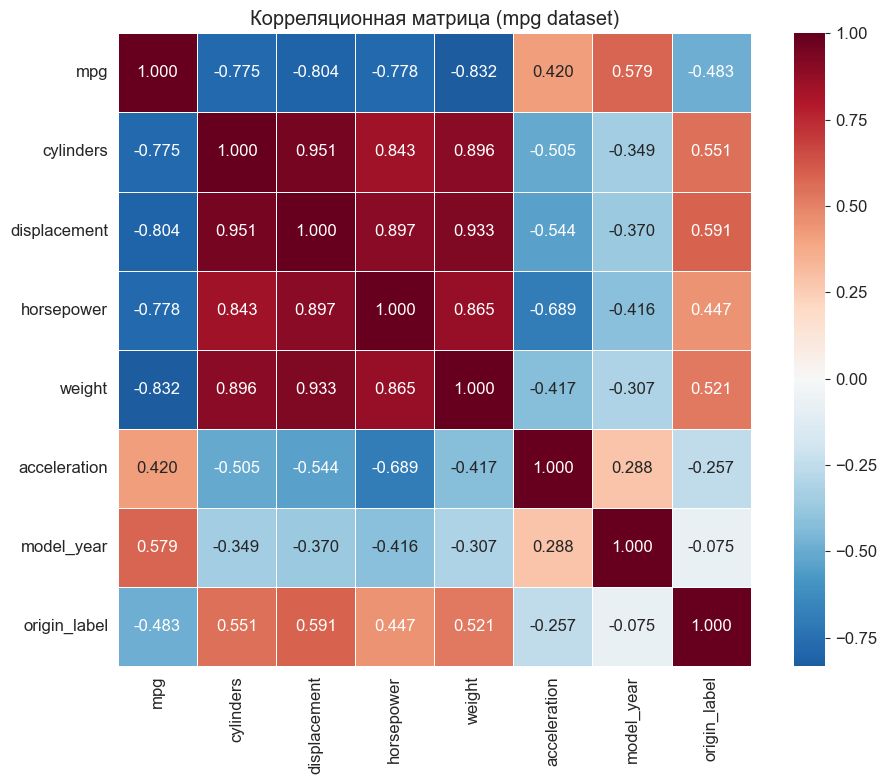

Корреляция признаков с целевым (mpg):
mpg             1.000
model_year      0.579
acceleration    0.420
origin_label   -0.483
cylinders      -0.775
horsepower     -0.778
displacement   -0.804
weight         -0.832
Name: mpg, dtype: float64


In [14]:
corr_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
             'acceleration', 'model_year', 'origin_label']
corr_matrix = df_mpg_encoded[corr_cols].corr().round(3)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', linewidths=0.5)
plt.title('Корреляционная матрица (mpg dataset)')
plt.tight_layout()
plt.savefig('corr_mpg.png', dpi=150, bbox_inches='tight')
plt.show()

print('Корреляция признаков с целевым (mpg):')
print(corr_matrix['mpg'].sort_values(ascending=False))

## 1.6 Градиентный спуск

Реализуем обычный (пакетный) и стохастический градиентный спуск для линейной регрессии:

$$y = w_0 + w_1 \cdot x$$

где $y$ = mpg, $x$ = horsepower.

In [15]:
# Подготовка данных
df_gd = df_mpg[['horsepower', 'mpg']].dropna()
x_raw = df_gd['horsepower'].values
y_raw = df_gd['mpg'].values

# Нормализация
x_mean, x_std = x_raw.mean(), x_raw.std()
y_mean, y_std = y_raw.mean(), y_raw.std()
x_norm = (x_raw - x_mean) / x_std
y_norm = (y_raw - y_mean) / y_std

n = len(x_norm)
print(f'Количество наблюдений: {n}')

Количество наблюдений: 392


In [16]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# === Обычный (batch) градиентный спуск ===
def batch_gradient_descent(x, y, lr=0.1, epochs=100):
    w0, w1 = 0.0, 0.0
    n = len(x)
    history = []
    for epoch in range(epochs):
        y_pred = w0 + w1 * x
        error = y_pred - y
        dw0 = (2 / n) * np.sum(error)
        dw1 = (2 / n) * np.sum(error * x)
        w0 -= lr * dw0
        w1 -= lr * dw1
        history.append(mse(y, w0 + w1 * x))
    return w0, w1, history

# === Стохастический (SGD) градиентный спуск ===
def stochastic_gradient_descent(x, y, lr=0.01, epochs=100):
    w0, w1 = 0.0, 0.0
    n = len(x)
    history = []
    np.random.seed(42)
    for epoch in range(epochs):
        indices = np.random.permutation(n)
        for i in indices:
            y_pred = w0 + w1 * x[i]
            error = y_pred - y[i]
            w0 -= lr * 2 * error
            w1 -= lr * 2 * error * x[i]
        history.append(mse(y, w0 + w1 * x))
    return w0, w1, history

# Запуск
w0_bgd, w1_bgd, hist_bgd = batch_gradient_descent(x_norm, y_norm, lr=0.1, epochs=100)
w0_sgd, w1_sgd, hist_sgd = stochastic_gradient_descent(x_norm, y_norm, lr=0.01, epochs=100)

print('=== Batch Gradient Descent ===')
print(f'w0 = {w0_bgd:.4f}, w1 = {w1_bgd:.4f}')
print(f'MSE (финальное): {hist_bgd[-1]:.6f}')

print(f'\n=== Stochastic Gradient Descent ===')
print(f'w0 = {w0_sgd:.4f}, w1 = {w1_sgd:.4f}')
print(f'MSE (финальное): {hist_sgd[-1]:.6f}')

=== Batch Gradient Descent ===
w0 = 0.0000, w1 = -0.7784
MSE (финальное): 0.394052

=== Stochastic Gradient Descent ===
w0 = -0.0026, w1 = -0.6981
MSE (финальное): 0.400508


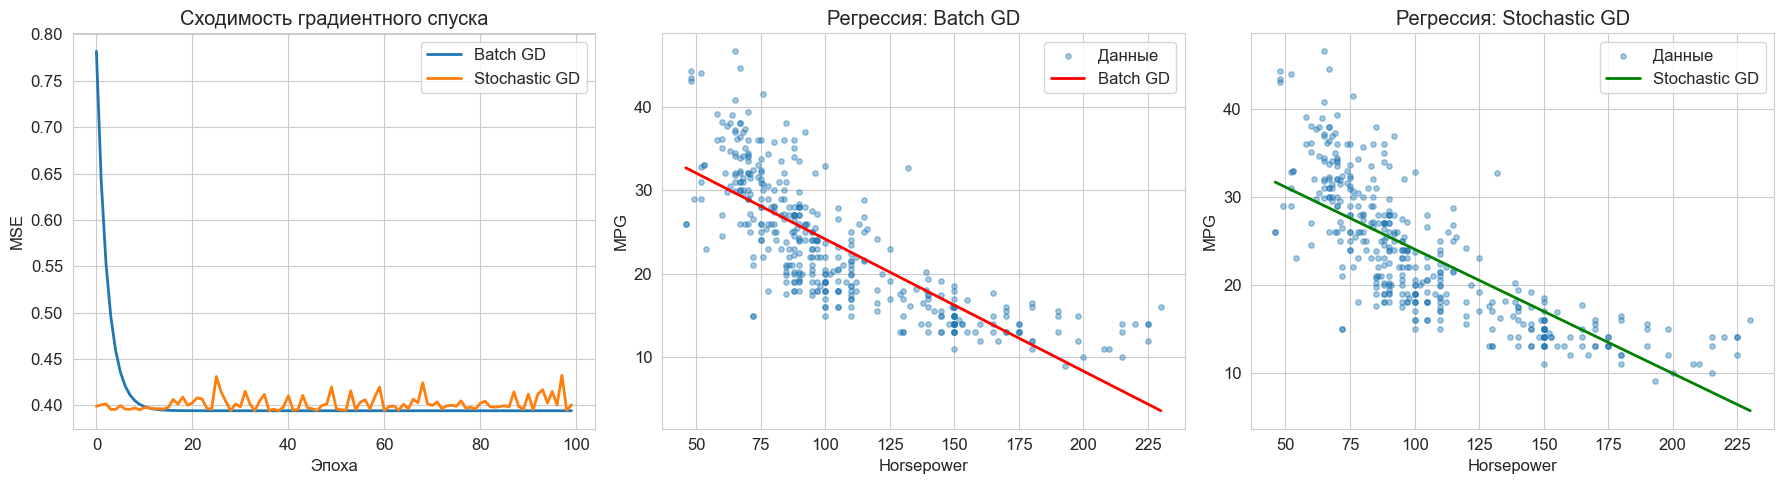

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Сходимость
axes[0].plot(hist_bgd, label='Batch GD', linewidth=2)
axes[0].plot(hist_sgd, label='Stochastic GD', linewidth=2)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('MSE')
axes[0].set_title('Сходимость градиентного спуска')
axes[0].legend()
axes[0].grid(True)

# 2. Регрессия (Batch)
axes[1].scatter(x_raw, y_raw, alpha=0.4, s=15, label='Данные')
x_line = np.linspace(x_raw.min(), x_raw.max(), 100)
x_line_norm = (x_line - x_mean) / x_std
y_line_norm = w0_bgd + w1_bgd * x_line_norm
y_line = y_line_norm * y_std + y_mean
axes[1].plot(x_line, y_line, 'r-', linewidth=2, label='Batch GD')
axes[1].set_xlabel('Horsepower')
axes[1].set_ylabel('MPG')
axes[1].set_title('Регрессия: Batch GD')
axes[1].legend()

# 3. Регрессия (SGD)
axes[2].scatter(x_raw, y_raw, alpha=0.4, s=15, label='Данные')
y_line_norm_sgd = w0_sgd + w1_sgd * x_line_norm
y_line_sgd = y_line_norm_sgd * y_std + y_mean
axes[2].plot(x_line, y_line_sgd, 'g-', linewidth=2, label='Stochastic GD')
axes[2].set_xlabel('Horsepower')
axes[2].set_ylabel('MPG')
axes[2].set_title('Регрессия: Stochastic GD')
axes[2].legend()

plt.tight_layout()
plt.savefig('gradient_descent.png', dpi=150, bbox_inches='tight')
plt.show()

**Вывод:** Оба метода градиентного спуска сходятся к близким значениям параметров. Batch GD сходится более плавно, тогда как SGD — с колебаниями, но быстрее на больших данных. Линейная модель подтверждает отрицательную зависимость mpg от horsepower.

---
# Часть 2. Самостоятельное задание — Nashville Housing
---

## 2.1 Загрузка данных из SQLite

In [18]:
conn = sqlite3.connect('../lab1/nashville_housing.db')
df_housing = pd.read_sql('SELECT * FROM housing', conn)
conn.close()

print(f'Загружено: {df_housing.shape[0]} строк, {df_housing.shape[1]} столбцов')
df_housing.head()

Загружено: 56477 строк, 19 столбцов


,UniqueID,ParcelID,LandUse,PropertyAddress,SaleDate,SalePrice,LegalReference,SoldAsVacant,OwnerName,OwnerAddress,Acreage,TaxDistrict,LandValue,BuildingValue,TotalValue,YearBuilt,Bedrooms,FullBath,HalfBath
0,0,105 03 0D 008.00,RESIDENTIAL CONDO,"1208 3RD AVE S, NASHVILLE","January 24, 2013",132000.0,20130128-0008725,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,105 11 0 080.00,SINGLE FAMILY,"1802 STEWART PL, NASHVILLE","January 11, 2013",191500.0,20130118-0006337,No,"STINSON, LAURA M.","1802 STEWART PL, NASHVILLE, TN",0.17,URBAN SERVICES DISTRICT,32000.0,134400.0,168300.0,1941.0,2.0,1.0,0.0
2,2,118 03 0 130.00,SINGLE FAMILY,"2761 ROSEDALE PL, NASHVILLE","January 18, 2013",202000.0,20130124-0008033,No,"NUNES, JARED R.","2761 ROSEDALE PL, NASHVILLE, TN",0.11,CITY OF BERRY HILL,34000.0,157800.0,191800.0,2000.0,3.0,2.0,1.0
3,3,119 01 0 479.00,SINGLE FAMILY,"224 PEACHTREE ST, NASHVILLE","January 18, 2013",32000.0,20130128-0008863,No,"WHITFORD, KAREN","224 PEACHTREE ST, NASHVILLE, TN",0.17,URBAN SERVICES DISTRICT,25000.0,243700.0,268700.0,1948.0,4.0,2.0,0.0
4,4,119 05 0 186.00,SINGLE FAMILY,"316 LUTIE ST, NASHVILLE","January 23, 2013",102000.0,20130131-0009929,No,"HENDERSON, JAMES P. & LYNN P.","316 LUTIE ST, NASHVILLE, TN",0.34,URBAN SERVICES DISTRICT,25000.0,138100.0,164800.0,1910.0,2.0,1.0,0.0


## 2.2 Преобразования и вычисляемые столбцы

In [19]:
# 1. SaleYear из SaleDate
df_housing['SaleYear'] = pd.to_datetime(df_housing['SaleDate'], format='mixed').dt.year
print(f'SaleYear: мин={df_housing["SaleYear"].min()}, макс={df_housing["SaleYear"].max()}')

# 2. PriceDiff = SalePrice - TotalValue
df_housing['PriceDiff'] = df_housing['SalePrice'] - df_housing['TotalValue']
print(f'PriceDiff: среднее={df_housing["PriceDiff"].mean():,.0f}')

# 3. LabelEncoding для LandUse
le_land = LabelEncoder()
df_housing['LandUse_encoded'] = le_land.fit_transform(df_housing['LandUse'].astype(str))
print(f'LandUse: {len(le_land.classes_)} категорий закодировано')

# 4. SoldAsVacant: Yes/No -> 1/0
df_housing['SoldAsVacant_num'] = df_housing['SoldAsVacant'].map({'Yes': 1, 'No': 0})
print(f'SoldAsVacant_num: {df_housing["SoldAsVacant_num"].value_counts().to_dict()}')

print(f'\nИтого после преобразований: {df_housing.shape[0]} строк, {df_housing.shape[1]} столбцов')
df_housing[['SaleDate', 'SaleYear', 'SalePrice', 'TotalValue', 'PriceDiff',
            'LandUse', 'LandUse_encoded', 'SoldAsVacant', 'SoldAsVacant_num']].head()

SaleYear: мин=2013, макс=2019
PriceDiff: среднее=48,352
LandUse: 39 категорий закодировано
SoldAsVacant_num: {0.0: 51403, 1.0: 4623}

Итого после преобразований: 56477 строк, 23 столбцов


,SaleDate,SaleYear,SalePrice,TotalValue,PriceDiff,LandUse,LandUse_encoded,SoldAsVacant,SoldAsVacant_num
0,"January 24, 2013",2013,132000.0,NaN,NaN,RESIDENTIAL CONDO,24,No,0.0
1,"January 11, 2013",2013,191500.0,168300.0,23200.0,SINGLE FAMILY,26,No,0.0
2,"January 18, 2013",2013,202000.0,191800.0,10200.0,SINGLE FAMILY,26,No,0.0
3,"January 18, 2013",2013,32000.0,268700.0,-236700.0,SINGLE FAMILY,26,No,0.0
4,"January 23, 2013",2013,102000.0,164800.0,-62800.0,SINGLE FAMILY,26,No,0.0


## 2.3 Разведочный анализ (EDA)

### 2.3.1 Числовые переменные

In [20]:
num_cols_h = ['SalePrice', 'Acreage', 'LandValue', 'BuildingValue', 'TotalValue',
              'YearBuilt', 'Bedrooms', 'FullBath', 'HalfBath',
              'SaleYear', 'PriceDiff', 'LandUse_encoded', 'SoldAsVacant_num']

eda_h_num = pd.DataFrame(index=num_cols_h)
eda_h_num['Пропуски (%)'] = (df_housing[num_cols_h].isnull().sum() / len(df_housing) * 100).round(2)
eda_h_num['Мин'] = df_housing[num_cols_h].min().round(2)
eda_h_num['Макс'] = df_housing[num_cols_h].max().round(2)
eda_h_num['Среднее'] = df_housing[num_cols_h].mean().round(2)
eda_h_num['Медиана'] = df_housing[num_cols_h].median().round(2)
eda_h_num['Дисперсия'] = df_housing[num_cols_h].var().round(2)
eda_h_num['Квантиль 0.1'] = df_housing[num_cols_h].quantile(0.1).round(2)
eda_h_num['Квантиль 0.9'] = df_housing[num_cols_h].quantile(0.9).round(2)
eda_h_num['Q1'] = df_housing[num_cols_h].quantile(0.25).round(2)
eda_h_num['Q3'] = df_housing[num_cols_h].quantile(0.75).round(2)

eda_h_num

,Пропуски (%),Мин,Макс,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Q1,Q3
SalePrice,0.01,50.00,54278060.00,327226.28,205226.00,8.646820e+11,87000.00,527500.00,135000.00,328500.00
Acreage,53.94,0.01,160.06,0.50,0.27,2.470000e+00,0.15,0.98,0.18,0.45
LandValue,53.94,100.00,2772000.00,69068.56,28800.00,1.124451e+10,15000.00,195000.00,21000.00,60000.00
BuildingValue,53.94,0.00,12971800.00,160784.68,111400.00,4.276618e+10,41700.00,301420.00,75900.00,180700.00
TotalValue,53.94,100.00,13940400.00,232375.40,148500.00,7.899717e+10,65000.00,458160.00,102800.00,268350.00
YearBuilt,57.22,1799.00,2017.00,1963.74,1960.00,7.045300e+02,1930.00,2007.00,1948.00,1983.00
Bedrooms,57.23,0.00,11.00,3.09,3.00,7.300000e-01,2.00,4.00,3.00,3.00
FullBath,57.02,0.00,10.00,1.89,2.00,9.200000e-01,1.00,3.00,1.00,2.00
HalfBath,57.25,0.00,3.00,0.28,0.00,2.400000e-01,0.00,1.00,0.00,1.00
SaleYear,0.00,2013.00,2019.00,2014.60,2015.00,1.140000e+00,2013.00,2016.00,2014.00,2015.00


### 2.3.2 Категориальные переменные

In [21]:
cat_cols_h = ['LandUse', 'SoldAsVacant', 'TaxDistrict']

eda_h_cat = pd.DataFrame(index=cat_cols_h)
eda_h_cat['Пропуски (%)'] = (df_housing[cat_cols_h].isnull().sum() / len(df_housing) * 100).round(2)
eda_h_cat['Уникальные'] = df_housing[cat_cols_h].nunique()
eda_h_cat['Мода'] = [df_housing[col].mode()[0] for col in cat_cols_h]

eda_h_cat

,Пропуски (%),Уникальные,Мода
LandUse,0.00,39,SINGLE FAMILY
SoldAsVacant,0.00,4,No
TaxDistrict,53.94,7,URBAN SERVICES DISTRICT


## 2.4 Статистические гипотезы

### Гипотеза 1: Цена продажи различается для SINGLE FAMILY и RESIDENTIAL CONDO

- **H₀:** средняя SalePrice одинакова для SINGLE FAMILY и RESIDENTIAL CONDO
- **H₁:** средняя SalePrice различается

**Обоснование выбора критерия:**
- **Критерий:** t-критерий Уэлча (Welch's t-test)
- **Почему этот критерий:** сравниваем средние цены двух независимых групп объектов недвижимости (каждая сделка — отдельное наблюдение). Выборки большие (n_SF = 34 194, n_RC = 14 077 — обе >> 30), поэтому по ЦПТ нормальность распределения средних обеспечена. Используем критерий Уэлча, а не классический t-тест, т.к. группы различаются по размеру и предположительно по дисперсии цен (разные сегменты рынка).
- **Уровень значимости:** α = 0.05

In [22]:
price_sf = df_housing[df_housing['LandUse'] == 'SINGLE FAMILY']['SalePrice'].dropna()
price_rc = df_housing[df_housing['LandUse'] == 'RESIDENTIAL CONDO']['SalePrice'].dropna()

print(f'SINGLE FAMILY:    n={len(price_sf)}, среднее=${price_sf.mean():,.0f}')
print(f'RESIDENTIAL CONDO: n={len(price_rc)}, среднее=${price_rc.mean():,.0f}')

t_stat, p_value = stats.ttest_ind(price_sf, price_rc, equal_var=False)
print(f'\nt-статистика: {t_stat:.4f}')
print(f'p-value: {p_value:.6f}')

alpha = 0.05
if p_value < alpha:
    print(f'\np-value ({p_value:.6f}) < \u03b1 ({alpha}) => отвергаем H\u2080.')
    print('Вывод: цена продажи статистически значимо различается для частных домов и кондоминиумов.')
    print('Частные дома в среднем дороже кондоминиумов в Нэшвилле.')
else:
    print(f'\np-value ({p_value:.6f}) >= \u03b1 ({alpha}) => не отвергаем H\u2080.')

SINGLE FAMILY:    n=34194, среднее=$280,251
RESIDENTIAL CONDO: n=14077, среднее=$436,068

t-статистика: -10.6451
p-value: 0.000000

p-value (0.000000) < α (0.05) => отвергаем H₀.
Вывод: цена продажи статистически значимо различается для частных домов и кондоминиумов.
Частные дома в среднем дороже кондоминиумов в Нэшвилле.


### Гипотеза 2: Цена продажи различается для объектов SoldAsVacant=Yes и SoldAsVacant=No

- **H₀:** средняя SalePrice одинакова для SoldAsVacant=Yes и SoldAsVacant=No
- **H₁:** средняя SalePrice различается

**Обоснование выбора критерия:**
- **Критерий:** t-критерий Уэлча (Welch's t-test)
- **Почему этот критерий:** сравниваем средние цены двух независимых групп — объекты, проданные как свободный участок (Yes), и объекты с постройками (No). Наблюдения независимы (разные сделки). Выборки большие (n_Yes = 4 623, n_No = 51 396), что по ЦПТ обеспечивает нормальность. Критерий Уэлча выбран вместо классического t-теста, т.к. размеры групп сильно различаются (в 11 раз) и дисперсии цен могут быть неравны.
- **Уровень значимости:** α = 0.05

In [23]:
price_yes = df_housing[df_housing['SoldAsVacant'] == 'Yes']['SalePrice'].dropna()
price_no = df_housing[df_housing['SoldAsVacant'] == 'No']['SalePrice'].dropna()

print(f'SoldAsVacant=Yes: n={len(price_yes)}, среднее=${price_yes.mean():,.0f}')
print(f'SoldAsVacant=No:  n={len(price_no)}, среднее=${price_no.mean():,.0f}')

t_stat, p_value = stats.ttest_ind(price_yes, price_no, equal_var=False)
print(f'\nt-статистика: {t_stat:.4f}')
print(f'p-value: {p_value:.6f}')

alpha = 0.05
if p_value < alpha:
    print(f'\np-value ({p_value:.6f}) < \u03b1 ({alpha}) => отвергаем H\u2080.')
    print('Вывод: цена продажи статистически значимо различается для объектов,')
    print('проданных как свободный участок и объектов с постройками.')
else:
    print(f'\np-value ({p_value:.6f}) >= \u03b1 ({alpha}) => не отвергаем H\u2080.')

SoldAsVacant=Yes: n=4623, среднее=$312,157
SoldAsVacant=No:  n=51396, среднее=$331,241

t-статистика: -2.6460
p-value: 0.008158

p-value (0.008158) < α (0.05) => отвергаем H₀.
Вывод: цена продажи статистически значимо различается для объектов,
проданных как свободный участок и объектов с постройками.


## 2.5 Корреляционная матрица

**Целевой столбец: SalePrice** — рыночная цена продажи, ключевой показатель для анализа рынка недвижимости. Признаки: Acreage, LandValue, BuildingValue, TotalValue, YearBuilt, Bedrooms, FullBath, HalfBath, SaleYear, PriceDiff, LandUse_encoded, SoldAsVacant_num.

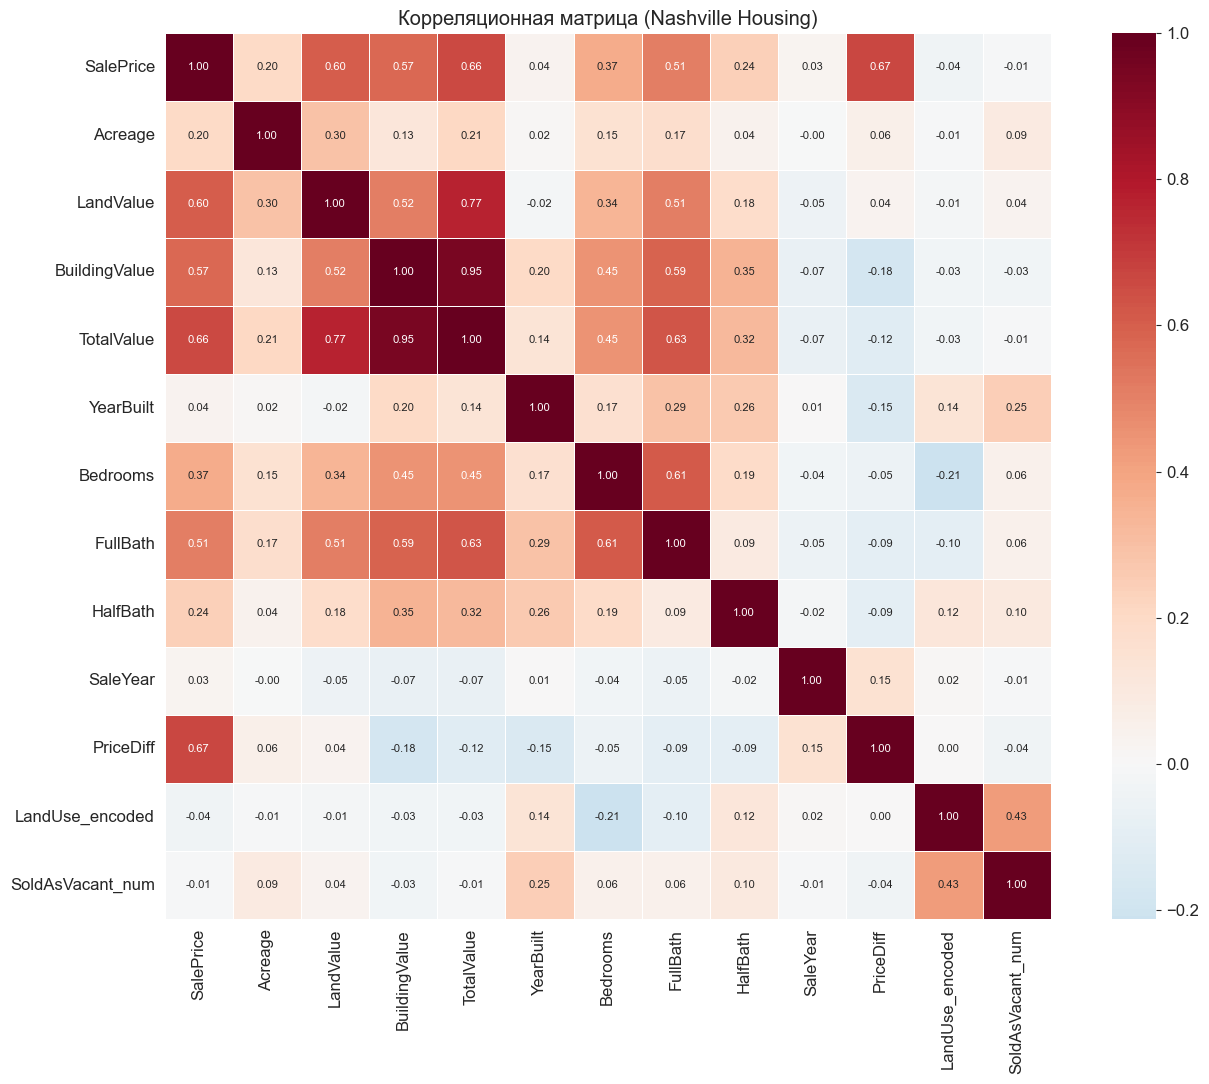

Корреляция признаков с целевым (SalePrice):
SalePrice           1.000
PriceDiff           0.667
TotalValue          0.662
LandValue           0.604
BuildingValue       0.575
FullBath            0.513
Bedrooms            0.373
HalfBath            0.239
Acreage             0.201
YearBuilt           0.037
SaleYear            0.025
SoldAsVacant_num   -0.006
LandUse_encoded    -0.042
Name: SalePrice, dtype: float64


In [24]:
corr_cols_h = ['SalePrice', 'Acreage', 'LandValue', 'BuildingValue', 'TotalValue',
               'YearBuilt', 'Bedrooms', 'FullBath', 'HalfBath',
               'SaleYear', 'PriceDiff', 'LandUse_encoded', 'SoldAsVacant_num']

corr_matrix_h = df_housing[corr_cols_h].corr().round(3)

plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix_h, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', linewidths=0.5, annot_kws={'size': 8})
plt.title('Корреляционная матрица (Nashville Housing)')
plt.tight_layout()
plt.savefig('corr_housing.png', dpi=150, bbox_inches='tight')
plt.show()

print('Корреляция признаков с целевым (SalePrice):')
print(corr_matrix_h['SalePrice'].sort_values(ascending=False))

## Заключение

### Часть 1 (mpg)
- Датасет mpg содержит 398 записей и 9 признаков
- Гипотеза 1: японские автомобили статистически значимо экономичнее американских
- Гипотеза 2: между весом и расходом топлива существует сильная отрицательная корреляция
- Реализованы Batch и Stochastic градиентный спуск для линейной регрессии mpg ~ horsepower

### Часть 2 (Nashville Housing)
- Датасет Nashville Housing содержит 56 477 записей
- Добавлены вычисляемые столбцы: SaleYear, PriceDiff, LandUse_encoded, SoldAsVacant_num
- Гипотеза 1: цены на частные дома и кондоминиумы статистически различаются
- Гипотеза 2: цена продажи различается для свободных участков и объектов с постройками
- Наиболее сильные корреляты SalePrice: TotalValue, BuildingValue, LandValue